In [262]:
%matplotlib inline
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd

print("TF version: ", tf.__version__)
print("Keras version: ", keras.__version__)

TF version:  2.5.0
Keras version:  2.5.0


In [2]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_dev, y_dev) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
rescale = keras.Sequential([layers.experimental.preprocessing.Rescaling(1.0/255)])

In [5]:
X_train = tf.reshape(rescale(X_train), shape=(-1, 28, 28, 1))
X_dev = tf.reshape(rescale(X_dev), shape=(-1, 28, 28, 1))

In [6]:
X_train.shape, X_dev.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [225]:
transformations = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.01),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomZoom((-0.1, 0.1))
])
X_train_transformed = transformations(X_train)
X_dev_transformed = transformations(X_dev)

In [226]:
def plot_img(img: np.array, label: int):
    print('Number:', label)
    plt.imshow(img.squeeze(), cmap='gray')

Number: 4


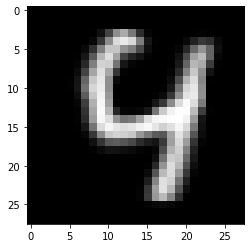

In [227]:
n = np.random.randint(X_train_transformed.shape[0])
plot_img(X_train_transformed[n].numpy(), y_train[n])

In [13]:
model = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)              

In [14]:
hist = model.fit(X_train_transformed, y_train,
    batch_size=32, epochs=15,
    validation_data=(X_dev_transformed, y_dev)
)

Epoch 1/10
1875/1875 [==============================] - 39s 5ms/step - loss: 0.3348 - accuracy: 0.8940 - val_loss: 0.0886 - val_accuracy: 0.9727
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1261 - accuracy: 0.9610 - val_loss: 0.0674 - val_accuracy: 0.9787
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0922 - accuracy: 0.9710 - val_loss: 0.0551 - val_accuracy: 0.9813
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0751 - accuracy: 0.9765 - val_loss: 0.0490 - val_accuracy: 0.9831
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0678 - accuracy: 0.9789 - val_loss: 0.0407 - val_accuracy: 0.9871
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0613 - accuracy: 0.9799 - val_loss: 0.0396 - val_accuracy: 0.9875
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0534 - accuracy: 0.9824 - val_loss: 0.0426 - val_accura

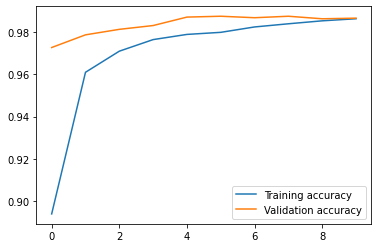

In [256]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

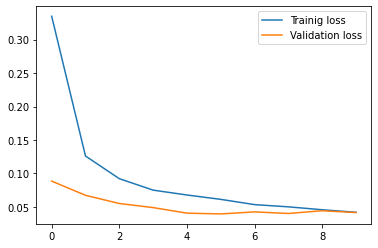

In [257]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

In [259]:
p_dev = np.argmax(model.predict(X_dev), axis=1)
p_train = np.argmax(model.predict(X_train), axis=1)

In [260]:
print("DEV F1 SCORE: ", f1_score(y_dev, p_dev, average='weighted'))
print("TRAIN F1 SCORE: ", f1_score(y_train, p_train, average='weighted'))

DEV F1 SCORE:  0.9932988158152987
TRAIN F1 SCORE:  0.9961164107285306


In [263]:
print("DEV CONFUSION MATRIX:")
pd.DataFrame(confusion_matrix(y_dev, p_dev))

DEV CONFUSION MATRIX:


,0,1,2,3,4,5,6,7,8,9
0,976,0,0,0,0,0,2,1,1,0
1,1,1127,1,2,0,0,2,1,1,0
2,0,1,1026,0,2,0,0,3,0,0
3,0,0,1,1008,0,1,0,0,0,0
4,0,0,0,0,980,0,0,0,1,1
5,0,0,0,5,0,886,1,0,0,0
6,2,4,0,0,1,2,948,0,1,0
7,0,2,3,0,2,0,0,1020,0,1
8,1,0,2,1,0,1,0,1,966,2
9,0,0,0,0,7,5,0,0,1,996


**TODO:**   
1. anomaly detection / outlier removal
2. Retrain the net with better data
3. test the network with external data
4. if succesful save the net and load in the web app, else repeat the steps again

In [18]:
p_train_logits = model.predict(X_train)

In [222]:
def clean_dataset(X, y, y_pred_logits, clean_percent: float = 0.1):
    N_TO_REMOVE = round(X.shape[0] * clean_percent)
    max_accuracies_array = np.array(y_pred_logits.max(axis=1))
    X_ = X.tolist()
    y_ = y.tolist()
    all_concat = list(zip(X_, y_, max_accuracies_array.tolist()))
    all_concat.sort(key=lambda x: x[2])
    X_new, y_new, _ = zip(*all_concat[N_TO_REMOVE:])
    return np.array(X_new), np.array(y_new)

In [250]:
X_train_clean, y_train_clean = clean_dataset(X_train.numpy(), y_train, p_train_logits, 0.05)
X_train_clean.shape, y_train_clean.shape

((57000, 28, 28, 1), (57000,))

In [267]:
X_train_clean_transformed = transformations(X_train_clean)

Number: 9


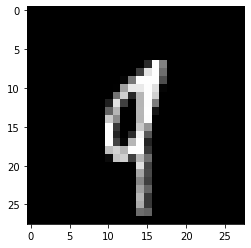

In [247]:
plot_img(X_train_clean[n], y_train_clean[n])

In [270]:
model2 = keras.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPool2D(2, 2),
    layers.Conv2D(16, (5, 5), activation='relu'),
    layers.MaxPool2D(2, 2),

    layers.Dropout(rate=0.3),

    layers.Flatten(),

    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=10, activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

In [271]:
hist2 = model2.fit(X_train_clean_transformed, y_train_clean, 
                   batch_size=32, epochs=10, validation_data=(X_dev_transformed, y_dev))

Epoch 1/10
1782/1782 [==============================] - 10s 5ms/step - loss: 0.2959 - accuracy: 0.9060 - val_loss: 0.0858 - val_accuracy: 0.9742
Epoch 2/10
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0901 - accuracy: 0.9720 - val_loss: 0.0660 - val_accuracy: 0.9798
Epoch 3/10
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0633 - accuracy: 0.9799 - val_loss: 0.0541 - val_accuracy: 0.9833
Epoch 4/10
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0515 - accuracy: 0.9843 - val_loss: 0.0560 - val_accuracy: 0.9833
Epoch 5/10
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0431 - accuracy: 0.9865 - val_loss: 0.0486 - val_accuracy: 0.9853
Epoch 6/10
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0386 - accuracy: 0.9873 - val_loss: 0.0605 - val_accuracy: 0.9827
Epoch 7/10
1782/1782 [==============================] - 9s 5ms/step - loss: 0.0340 - accuracy: 0.9892 - val_loss: 0.0484 - val_accuracy

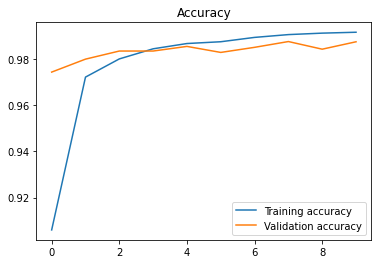

In [272]:
plt.title('Accuracy')
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show();

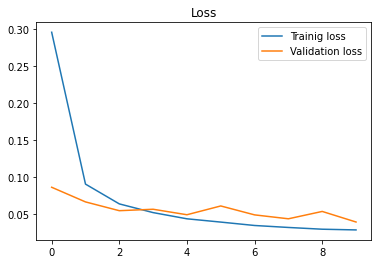

In [273]:
plt.title('Loss')
plt.plot(hist2.epoch, hist2.history['loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Trainig loss', 'Validation loss'])
plt.show();

## Comparando os modelos

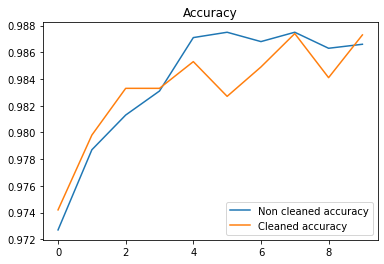

In [274]:
plt.title('Accuracy')
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['Non cleaned accuracy', 'Cleaned accuracy'])
plt.show();

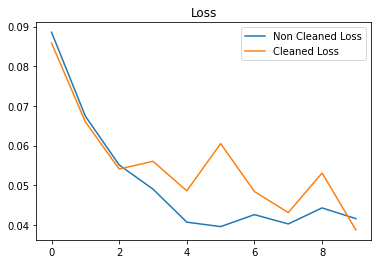

In [275]:
plt.title('Loss')
plt.plot(hist.epoch, hist.history['val_loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['Non Cleaned Loss', 'Cleaned Loss'])
plt.show();

In [277]:
print("Non cleaned F1 Score:", f1_score(y_dev, np.argmax(model.predict(X_dev), axis=1), average='weighted'))
print("Cleaned F1 Score:", f1_score(y_dev, np.argmax(model2.predict(X_dev), axis=1), average='weighted'))

Non cleaned F1 Score: 0.9932988158152987
Cleaned F1 Score: 0.9909054612950371


### Analysing  the results

Apparently, the model trained with the cleaned data seems to be working worse than the first one, but if we pay attention to the fact that the dev data was not cleaned although it was used for validating the model trained with the cleaned data, so in real data, the results may be different.